In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [78]:
from typing import Tuple

from dataset import Dataset
from plotting import plot_ts

dataset = Dataset('../data/dataset/')

### В чем заключаются недостатки полносвязных сетей?
* невозможность улавливать временные закономерности в контексте предыдущих точек (архитектурное ограничение)
* фиксированный размер входных данных
* фиксированный размер выходных данных

### Область применимости рекуретных сетей для задачи анализа временных рядов
* большое количество экзогенных признаков, имеющих сложную нелинейную зависимость с целевым рядом
* очень сложная временная структура имеющая наложение разных сезонных и цикличных паттернов
* ряды с часто меняющимся паттерном, или большим количеством аномалий
* когда есть необходимость в нефиксированной длине входных и выходных данных (например многомерные ряды, где для разных компонент хочется предоставить разное количество лагов) 

### Особенности подготовки данных - необходима нормализация данных, иначе сеть будет плохо сходиться и медленно обучаться.

In [79]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [87]:
data = np.array(range(0, 100, 10)).reshape(-1, 1)

In [88]:
scaler = MinMaxScaler((0, 1))

In [89]:
scaler.fit(data)

MinMaxScaler()

In [90]:
transformed = scaler.transform(data)

In [91]:
transformed

array([[0.        ],
       [0.11111111],
       [0.22222222],
       [0.33333333],
       [0.44444444],
       [0.55555556],
       [0.66666667],
       [0.77777778],
       [0.88888889],
       [1.        ]])

In [92]:
inverse = scaler.inverse_transform(transformed)

In [93]:
inverse

array([[ 0.],
       [10.],
       [20.],
       [30.],
       [40.],
       [50.],
       [60.],
       [70.],
       [80.],
       [90.]])

### Особенность подготвки данных - обработка последовательностей разной длины.

In [99]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [100]:
sequences = [
    [1, 2, 3, 4],
    [3, 4, 5],
    [5, 6],
    [3]
]

In [101]:
pad_sequences(sequences, padding='pre')

array([[1, 2, 3, 4],
       [0, 3, 4, 5],
       [0, 0, 5, 6],
       [0, 0, 0, 3]], dtype=int32)

In [102]:
pad_sequences(sequences, padding='post')

array([[1, 2, 3, 4],
       [3, 4, 5, 0],
       [5, 6, 0, 0],
       [3, 0, 0, 0]], dtype=int32)

In [103]:
pad_sequences(sequences, maxlen=2)

array([[3, 4],
       [4, 5],
       [5, 6],
       [0, 3]], dtype=int32)

In [104]:
pad_sequences(sequences, maxlen=2, truncating='post')

array([[1, 2],
       [3, 4],
       [5, 6],
       [0, 3]], dtype=int32)

### Какие архитектуры lstm нас интересуют в контексте временных рядов?
* one-to-one - предсказание следующей точки по предыдущей - нет
* one-to-many - предсказание следующих N точeк про предыдущей - нет
* many-to-one - one-step-ahead предсказание - в некоторой степени
* many-to-many -  предсказание вектора из следующих m точек по предыдущим n точкам - наибольший интерес

### Простая LSTM сеть

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [106]:
ts = dataset['daily-min-temperatures.csv']

<Axes: xlabel='1981-01-01'>

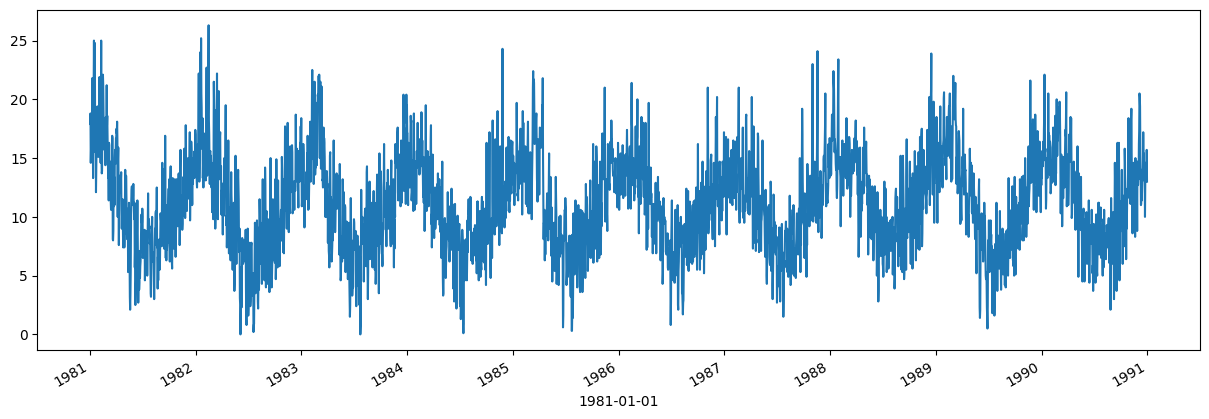

In [107]:
ts.plot(figsize=(15, 5))

In [109]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> Tuple[np.array]:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [110]:
NUM_LAGS = 14
X, y = transform_into_matrix(ts, NUM_LAGS)

In [111]:
X[0]

array([17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3,
       16.7, 21.5, 25. ])

In [113]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [114]:
X[0]

array([[17.9],
       [18.8],
       [14.6],
       [15.8],
       [15.8],
       [15.8],
       [17.4],
       [21.8],
       [20. ],
       [16.2],
       [13.3],
       [16.7],
       [21.5],
       [25. ]])

In [115]:
split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [117]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [118]:
model.fit(X, y, epochs=100)

Epoch 1/100
114/114 [==============================] - 1s 2ms/step - loss: 15.2133
Epoch 2/100
114/114 [==============================] - 0s 2ms/step - loss: 6.3229
Epoch 3/100
114/114 [==============================] - 0s 2ms/step - loss: 5.9155
Epoch 4/100
114/114 [==============================] - 0s 2ms/step - loss: 5.9387
Epoch 5/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8956
Epoch 6/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8242
Epoch 7/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8696
Epoch 8/100
114/114 [==============================] - 0s 2ms/step - loss: 5.9192
Epoch 9/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8374
Epoch 10/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8834
Epoch 11/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8258
Epoch 12/100
114/114 [==============================] - 0s 2ms/step - loss: 5.8672
Epoch 13/100

In [31]:
y_pred = model.predict(X_test)

<Axes: >

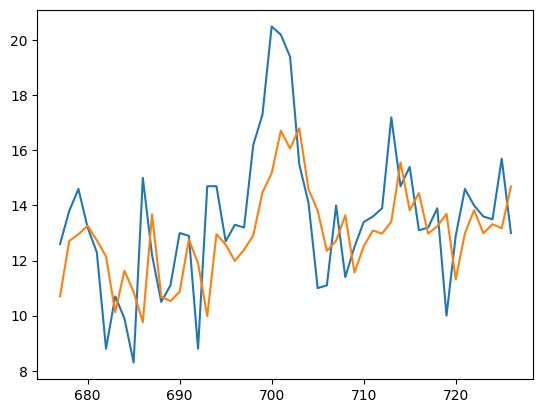

In [130]:
pd.Series(y_test.flatten())[-50:].plot()
pd.Series(y_pred.flatten())[-50:].plot()

In [33]:
### данный результат на самом деле не сильно лучше наивного предсказания

In [33]:
from sklearn.metrics import mean_squared_error as mse

In [34]:
mse(y_test.flatten(), y_pred.flatten())

4.548428771578284

### Stacked LSTM

#### Добавьте дополнительные скрытые слои в сеть (используйте return_sequences=True) и сравните качество

In [141]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1), return_sequences=True))
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [132]:
model.fit(X_train, y_train, epochs=100, verbose=0)

In [133]:
y_pred = model.predict(X_test)

23/23 [==============================] - 0s 2ms/step


<Axes: >

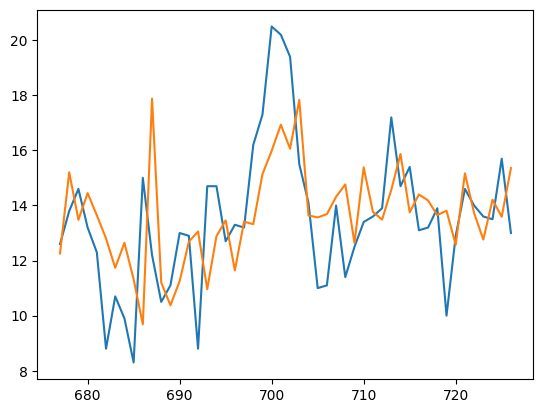

In [134]:
pd.Series(y_test.flatten())[-50:].plot()
pd.Series(y_pred.flatten())[-50:].plot()

In [136]:
mse(y_test.flatten(), y_pred.flatten())

5.403300603717677

### Bidirectional LSTM

#### Сделаем LSTM слой сети Bidirectional при помощи доп слоя Biderectional и сравним качество

In [137]:
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1), return_sequences=True))
model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(NUM_LAGS, 1))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [138]:
model.fit(X_train, y_train, epochs=10, verbose=0)

In [139]:
y_pred = model.predict(X_test)

23/23 [==============================] - 0s 2ms/step


In [140]:
mse(y_test.flatten(), y_pred.flatten())

5.132437860726388

### Seq2Seq LSTM - когда нужно сделать предсказание на несколько точек вперед

#### Подготовим данные

In [148]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

In [149]:
# получите X и y при помощи предыдущей функции и разбейте на трейн и тест 
NUM_LAGS_IN = 28
NUM_LAGS_OUT = 7

X, y = transform_ts_into_matrix(ts, NUM_LAGS_IN, NUM_LAGS_OUT)

In [150]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [151]:
X.shape

(3615, 28, 1)

In [152]:
y.shape

(3615, 7)

In [153]:
split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [154]:
# объявим енкодер
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(NUM_LAGS_IN, 1)))

In [155]:
# добавим промежуточный слой, преобразующий выход с енкодера для входного слоя в декодер
from tensorflow.keras.layers import RepeatVector
model.add(RepeatVector(NUM_LAGS_OUT))

In [156]:
# обьявим декодер
model.add(LSTM(50, activation='relu', return_sequences=True))

In [157]:
# обьявим выходной слой - размерность на выходе получается при помощи дополнительного слоя TimeDistributed
from tensorflow.keras.layers import TimeDistributed
model.add(TimeDistributed(Dense(1)))

#### Обучим модель и получим предсказание на тесте

In [158]:
model.compile(optimizer='adam', loss='mse')

In [159]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 100)               40800     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 7, 100)            0         
 tor)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 7, 50)             30200     
                                                                 
 time_distributed_2 (TimeDi  (None, 7, 1)              51        
 stributed)                                                      
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [160]:
model.fit(X_train, y_train, epochs=10, verbose=0)

In [161]:
y_pred = model.predict(X_test)

23/23 [==============================] - 0s 3ms/step


In [162]:
y_pred.flatten()

array([14.079471, 14.218849, 14.324762, ..., 13.539443, 13.389404,
       13.360301], dtype=float32)

In [163]:
mse(y_test.flatten(), y_pred.flatten())

6.952048979918201

### Пример с многомерным рядом.

In [164]:
ts_multi = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [165]:
ts_multi.fillna(ts_multi.mean(), axis=0, inplace=True)

In [166]:
ts_multi.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


In [167]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x)
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [168]:
X[0]

array([[17.9],
       [18.8],
       [14.6],
       [15.8],
       [15.8],
       [15.8],
       [17.4],
       [21.8],
       [20. ],
       [16.2],
       [13.3],
       [16.7],
       [21.5],
       [25. ],
       [20.7],
       [20.6],
       [24.8],
       [17.7],
       [15.5],
       [18.2],
       [12.1],
       [14.4],
       [16. ],
       [16.5],
       [18.7],
       [19.4],
       [17.2],
       [15.5]])

In [169]:
NUM_LAGS = 14
N_DIMS = ts_multi.shape[1]
X, y = transform_multi_ts_into_matrix(ts_multi, NUM_LAGS)

In [170]:
X[0].shape

(14, 9)

In [171]:
# объявим енкодер
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(NUM_LAGS, N_DIMS)))

In [71]:
# добавим промежуточный слой, преобразующий выход с енкодера для входного слоя в декодер
from keras.layers import RepeatVector
model.add(RepeatVector(N_DIMS))

In [72]:
# обьявим декодер
model.add(LSTM(50, activation='relu', return_sequences=True))

In [73]:
# обьявим выходной слой - размерность на выходе получается при помощи дополнительного слоя TimeDistributed
from keras.layers import TimeDistributed
model.add(TimeDistributed(Dense(1)))

In [74]:
model.compile(optimizer='adam', loss='mse')

In [75]:
model.fit(X, y, epochs=50)

Epoch 1/50
130/130 [==============================] - 1s 6ms/step - loss: 5999.7275
Epoch 2/50
130/130 [==============================] - 1s 6ms/step - loss: 3777.0024
Epoch 3/50
130/130 [==============================] - 1s 6ms/step - loss: 5287.5801
Epoch 4/50
130/130 [==============================] - 1s 6ms/step - loss: 3602.5403
Epoch 5/50
130/130 [==============================] - 1s 6ms/step - loss: 2959.6770
Epoch 6/50
130/130 [==============================] - 1s 6ms/step - loss: 2576.1541
Epoch 7/50
130/130 [==============================] - 1s 6ms/step - loss: 2884.8616
Epoch 8/50
130/130 [==============================] - 1s 6ms/step - loss: 3627.1055
Epoch 9/50
130/130 [==============================] - 1s 6ms/step - loss: 4065.6665
Epoch 10/50
130/130 [==============================] - 1s 6ms/step - loss: 2362.0586
Epoch 11/50
130/130 [==============================] - 1s 6ms/step - loss: 2561.5496
Epoch 12/50
130/130 [==============================] - 1s 6ms/step - loss: